<a href="https://colab.research.google.com/github/Oumayma-O/Tp4_Deep_learning/blob/main/TP4_RNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Importation du dataset :

In [ ]:
import seaborn as sns


In [ ]:
dataset_path = "/content/drive/MyDrive/Tp4Dataset/IMDB Dataset.csv"
imdb_df = pd.read_csv(dataset_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Dimensions du dataset:", imdb_df.shape)


Dimensions du dataset: (50000, 2)


In [ ]:
print("Valeurs NULL dans le dataset:\n", imdb_df.isnull().sum())


Valeurs NULL dans le dataset:
 review       0
sentiment    0
dtype: int64


In [ ]:
print("Les cinq premières lignes du dataset:\n", imdb_df.head())


Les cinq premières lignes du dataset:
                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


<Axes: xlabel='sentiment', ylabel='count'>

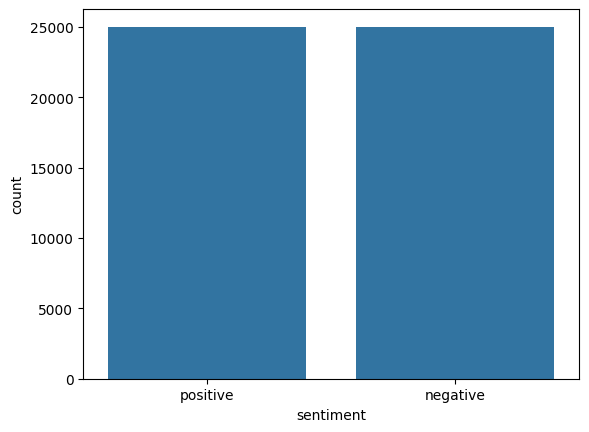

In [ ]:
sns.countplot(data=imdb_df, x='sentiment')


In [ ]:
print("Quatrième avis:\n", imdb_df['review'][3])


Quatrième avis:
 Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


# Prétraitement de données :

In [ ]:
def preprocess_text(sen):
 # Removing html tags
 sentence = remove_tags(sen)
 # Remove punctuations and numbers
 sentence = re.sub('[^a-zA-Z]', ' ', sentence)
 # Single character removal
 sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
 # Removing multiple spaces
 sentence = re.sub(r'\s+', ' ', sentence)
 return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
 return TAG_RE.sub('', text)

Ce code définit une fonction **preprocess_text(sen)** qui effectue plusieurs étapes de prétraitement sur du texte. Voici ce que chaque étape fait :

1. **remove_tags(sen)**: Cette fonction prend une chaîne de caractères `sen` en entrée et utilise une expression régulière (`TAG_RE`) pour supprimer toutes les balises HTML de la chaîne. Elle retourne la chaîne sans les balises HTML.

2. **re.sub('[^a-zA-Z]', ' ', sentence)**: Cette ligne utilise la fonction `re.sub()` de la bibliothèque `re` pour remplacer tous les caractères qui ne sont pas des lettres de l'alphabet (majuscules ou minuscules) par un espace dans la chaîne `sentence`. Cela supprime efficacement la ponctuation, les chiffres et d'autres caractères spéciaux de la chaîne.

3. **re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)**: Cette ligne utilise à nouveau `re.sub()` pour remplacer tous les caractères alphabétiques uniques entourés d'espaces par un seul espace. Cela élimine les caractères alphabétiques qui ne sont pas précédés ou suivis d'autres caractères alphabétiques, ce qui peut être considéré comme du bruit dans le texte.

4. **re.sub(r'\s+', ' ', sentence)**: Cette ligne remplace toutes les séquences d'espaces (y compris les espaces multiples) par un seul espace. Cela assure que le texte final n'a pas de doubles espaces.

La fonction `preprocess_text(sen)` prend un texte en entrée, applique ces étapes de prétraitement dans l'ordre, et retourne le texte prétraité.

In [ ]:
X = []
sentences = list(imdb_df['review'])
for sen in sentences:
 X.append(preprocess_text(sen))


### Réafficher le 4ème review. Que remarquez-vous ?

In [ ]:
print(X[3])

Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 



1. **Suppression des balises HTML :** Les balises HTML telles que `<br />`ont été supprimé.

2. **Suppression de la ponctuation et des chiffres :** La ponctuation , les parenthéses et les chiffres ont été supprimé.

3. **Suppression des caractères alphabétiques uniques :** Les lettres isolées qui ne sont pas précédées ou suivies d'autres lettres alphabétiques ont été isolé.

En appliquant ces transformations, on obtient un texte nettoyé , prêt à être utilisé dans des tâches d'analyse telles que l'analyse de sentiment, la classification de texte ou la génération de modèles linguistiques.

### Conversion des étiquettes en chiffres

In [ ]:
y = imdb_df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

### Diviser le dataset en training et test sets

In [ ]:
X_train_0, X_test_0, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)

print(len(X_train_0))
print(len(X_test_0))

40000
10000


# La couche de l’embedding

### Tokenize data and store it into sequences

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_0)
X_train = tokenizer.texts_to_sequences(X_train_0)
X_test = tokenizer.texts_to_sequences(X_test_0)



1. **Création d'un dictionnaire word-to-index avec Tokenizer :** Le Tokenizer de Keras est utilisé pour créer un dictionnaire qui mappe chaque mot unique du corpus (ensemble de données) à un index unique. Cela signifie que chaque mot obtient un nombre entier unique qui le représente dans le dictionnaire. Par exemple, si notre corpus contient les phrases "le chat dort" et "le chien court", le dictionnaire pourrait ressembler à {"le": 1, "chat": 2, "dort": 3, "chien": 4, "court": 5}.

2. **Conversion des textes en séquences d'entiers :** Une fois que le dictionnaire word-to-index est créé, chaque phrase du jeu de données est convertie en une séquence d'entiers, où chaque entier correspond à l'index du mot dans le dictionnaire. Par exemple, si une phrase est "le chat dort", elle pourrait être convertie en la séquence d'entiers [1, 2, 3].



### Remplissage des séquences

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(40000, 100)
(10000, 100)


In [ ]:
print(f"vocab_size :",vocab_size)

vocab_size : 92547


In [ ]:
print(X_train)

[[   4    1  296 ...  198  345 3812]
 [   1  412  100 ...   82   99    6]
 [ 128 1307  108 ...    0    0    0]
 ...
 [ 778    8   24 ...    0    0    0]
 [   8  347   10 ...    0    0    0]
 [ 274  100  121 ...   67   69 1946]]


`vocab_size = len(tokenizer.word_index) + 1`:
- `tokenizer.word_index` est un dictionnaire qui contient les mots uniques du corpus en tant que clés et leurs index correspondants en tant que valeurs.
- `len(tokenizer.word_index)` renvoie le nombre total de mots uniques dans le dictionnaire word-to-index.
- On ajoute 1 à cette valeur parce que les index commencent généralement à 1 plutôt qu'à 0. Ainsi, pour prendre en compte l'index 0, nous ajoutons 1 à la taille du vocabulaire.

Ainsi, `vocab_size` contient la taille totale du vocabulaire, c'est-à-dire le nombre total de mots uniques dans le corpus, y compris le token spécial pour les mots inconnus (0). Cela sera utile lors de la définition de la taille de la couche d'embedding dans un modèle de réseau de neurones.

 **Remplissage des séquences :** Comme les phrases ont des longueurs différentes, nous devons les égaliser pour pouvoir les utiliser dans un modèle de réseau de neurones. Pour ce faire, nous déterminons la longueur maximale des séquences et toutes les séquences plus courtes sont remplies avec des zéros à la fin pour les rendre de la même longueur. Par exemple, si la longueur maximale est 5 et une phrase a la séquence [1, 2, 3], elle serait remplie avec des zéros pour devenir [1, 2, 3, 0, 0].

### Chargement et création de la matrice d'embedding GloVe

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open("/content/drive/MyDrive/Tp4Dataset/glove.6B.100d.txt", encoding="utf8")

for i in range(5):
    line = glove_file.readline()
    print(line)

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

In [ ]:
for line in glove_file:
 records = line.split()
 word = records[0]
 vector_dimensions = asarray(records[1:],dtype='float32')
 embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
for word, embedding in embeddings_dictionary.items():
    print(f"Word: {word}, Embedding: {embedding}")
    break  # Stop after printing the first entry


Word: and, Embedding: [-0.071953  0.23127   0.023731 -0.50638   0.33923   0.1959   -0.32943
  0.18364  -0.18057   0.28963   0.20448  -0.5496    0.27399   0.58327
  0.20468  -0.49228   0.19974  -0.070237 -0.88049   0.29485   0.14071
 -0.1009    0.99449   0.36973   0.44554   0.28998  -0.1376   -0.56365
 -0.029365 -0.4122   -0.25269   0.63181  -0.44767   0.24363  -0.10813
  0.25164   0.46967   0.3755   -0.23613  -0.14129  -0.44537  -0.65737
 -0.042421 -0.28636  -0.28811   0.063766  0.20281  -0.53542   0.41307
 -0.59722  -0.38614   0.19389  -0.17809   1.6618   -0.011819 -2.3737
  0.058427 -0.2698    1.2823    0.81925  -0.22322   0.72932  -0.053211
  0.43507   0.85011  -0.42935   0.92664   0.39051   1.0585   -0.24561
 -0.18265  -0.5328    0.059518 -0.66019   0.18991   0.28836  -0.2434
  0.52784  -0.65762  -0.14081   1.0491    0.5134   -0.23816   0.69895
 -1.4813   -0.2487   -0.17936  -0.059137 -0.08056  -0.48782   0.014487
 -0.6259   -0.32367   0.41862  -1.0807    0.46742  -0.49931  -0.7189

These numbers are learned during the training of the GloVe model on a large corpus of text data. The specific meanings of the numbers themselves are not directly interpretable, but they capture the semantic context and relationships of the word "and" based on its co-occurrence patterns with other words in the training data.


 **Création de la matrice d'embeddings :**
   - Une matrice d'embeddings est initialisée avec des zéros. Elle a une taille de `(vocab_size, 100)` où `vocab_size` est la taille du vocabulaire et 100 est la dimension des embeddings GloVe que nous utilisons (dans cet exemple).
   - Pour chaque mot dans le vocabulaire de notre corpus (représenté par `tokenizer.word_index.items()`), le script récupère les embeddings correspondants à partir du dictionnaire créé précédemment.
   - Si le mot a des embeddings GloVe disponibles, ceux-ci sont ajoutés à la matrice d'embeddings à l'index correspondant à sa position dans le vocabulaire.

En résumé, cette partie du script crée une représentation numérique des mots de notre corpus en utilisant les embeddings GloVe pré-entraînés. Cela nous permet d'initialiser la couche d'embedding de notre modèle de réseau de neurones avec des poids qui capturent les similitudes sémantiques entre les mots, même pour les mots qui ne sont pas présents dans notre ensemble de données d'apprentissage initial.

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
 embedding_vector = embeddings_dictionary.get(word)
 if embedding_vector is not None:
     embedding_matrix[index] = embedding_vector

In [ ]:
# Affichage des premiers embeddings
for i in range(1, 10):  # Commencer à l'index 1
    print("Word:", tokenizer.index_word[i])
    print("Embedding:", embedding_matrix[i])


Word: the
Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Word: and
Embedding: [-0.071953    0.23127     0.023731   -0.50638002  0.33923     0.19589999
 -0.32943001  0.18364    -0.18057001  0.28963     0.20448001 -0.54960001
  0.27399001  0.58327001  0.20468    -0.49228001  0.19973999 -0.070237
 -0.88049001  0.29484999  0.14071    -0.1009      0.99449003  0.36973
  0.44554001  0.28997999 -0.1376     -0.56365001 -0.029365   -0.4122
 -0.25268999  0.63181001 -0.44767001  0.24363001 -0.10813     0.25163999
  0.46967     0.37549999 -0.23613    -0.14128999 -0.44536999 -0.65736997
 -0.042421   -0.28636    -0.28810999  0.063766    0.20281    -0.53542
  0.41306999 -0.59722    -0.38613999  0.19389001 -0.17809001  1.66180003
 -0.011

# A. Classification avec un simple réseau de neurones

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Création du modèle séquentiel
model = Sequential()

# Ajout de la couche Embedding: Cette couche est utilisée pour créer des représentations denses de mots dans l'espace vectoriel
#Les poids de cette couche sont initialisés avec des embeddings GloVe pré-entraînés.

model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#Les poids de cette couche sont figés (trainable=False), ce qui signifie qu'ils ne seront pas mis à jour pendant l'entraînement.

# Ajout de la couche Flatten: Cette couche est utilisée pour aplatir les données d'entrée en un vecteur unidimensionnel avant de les passer à la couche Dense suivante.
model.add(Flatten())

# Ajout de la couche Dense
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.5987 - acc: 0.6761 - val_loss: 0.5339 - val_acc: 0.7395
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4942 - acc: 0.7614 - val_loss: 0.5153 - val_acc: 0.7498
Epoch 3/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4522 - acc: 0.7903 - val_loss: 0.5171 - val_acc: 0.7467
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4339 - acc: 0.8018 - val_loss: 0.5206 - val_acc: 0.7480
Epoch 5/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4139 - acc: 0.8128 - val_loss: 0.5731 - val_acc: 0.7209
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4084 - acc: 0.8155 - val_loss: 0.5521 - val_acc: 0.7356


In [ ]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 9372077 (35.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluation du modéle

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5558 - acc: 0.7340
Test Score: 0.5557507276535034
Test Accuracy: 0.734000027179718


la perte de test(loss) est élevée , et la précision est moyenne

### Traçage des fonctions de loss et de accuracy pour les training et test sets


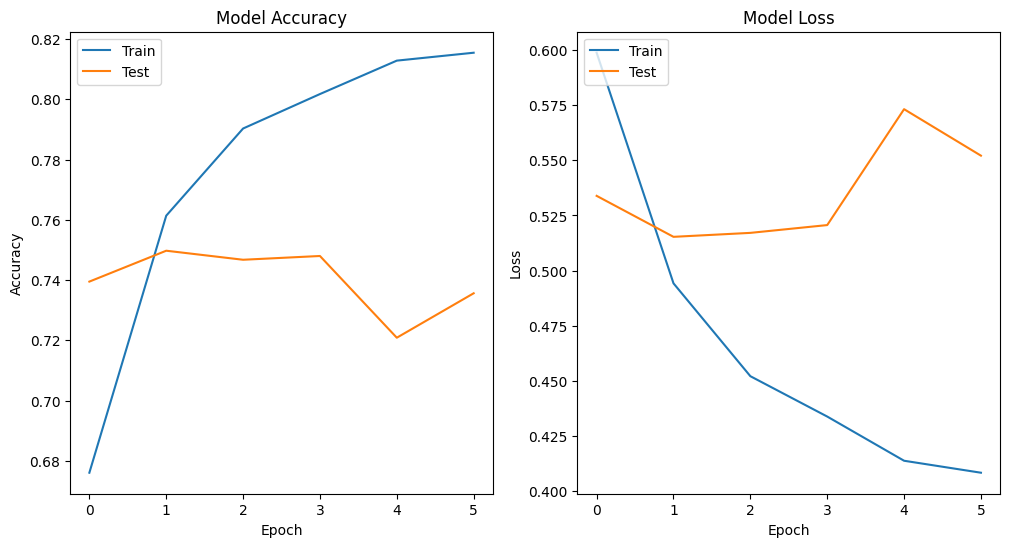

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()


What we observe from the plots is that during training, as the number of epochs increases, the accuracy on the training data steadily improves, reaching around 82%. However, on the test data, the accuracy initially increases but then fluctuates around 73%, indicating that the model may have some degree of overfitting as it performs better on the training data compared to unseen test data.

Regarding the loss, we notice a consistent decrease in the training loss as the epochs progress, indicating that the model is learning and fitting the training data better. However, on the test data, the loss initially decreases but then starts to increase around epoch 4, indicating that the model's performance begins to degrade slightly before improving again towards the end of training.

In conclusion, while the model demonstrates good performance on the training data, its performance on unseen test data is not as consistent. This suggests that the model might benefit from further regularization techniques or adjustments to improve its generalization ability and reduce overfitting.

# B. Classification avec un réseau de neurones convolutionnel (CNN)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense

# Création du modèle séquentiel
model = Sequential()

# Ajout de la couche d'embedding
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

# Ajout de la couche Conv1D
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Ajout de la couche de pooling MaxPooling1D
model.add(MaxPooling1D())

# Ajout de la couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

X_train = X_train.reshape(-1, maxlen, 1)
y_train = y_train.reshape(-1, 1)


# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 95s 367ms/step - loss: 0.6567 - acc: 0.6023 - val_loss: 0.6337 - val_acc: 0.6304
Epoch 2/6
250/250 [==============================] - 86s 342ms/step - loss: 0.6283 - acc: 0.6363 - val_loss: 0.6327 - val_acc: 0.6288
Epoch 3/6
250/250 [==============================] - 88s 353ms/step - loss: 0.6188 - acc: 0.6465 - val_loss: 0.6232 - val_acc: 0.6412
Epoch 4/6
250/250 [==============================] - 84s 336ms/step - loss: 0.6143 - acc: 0.6508 - val_loss: 0.6234 - val_acc: 0.6405
Epoch 5/6
250/250 [==============================] - 86s 343ms/step - loss: 0.6107 - acc: 0.6537 - val_loss: 0.6239 - val_acc: 0.6401
Epoch 6/6
250/250 [==============================] - 84s 335ms/step - loss: 0.6059 - acc: 0.6585 - val_loss: 0.6197 - val_acc: 0.6445


In [ ]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 9372077 (35.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluation du modele

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 7s 21ms/step - loss: 0.7933 - acc: 0.5044
Test Score: 0.7933429479598999
Test Accuracy: 0.5044310092926025


### Traçage des fonctions de loss et de accuracy pour les training et test sets


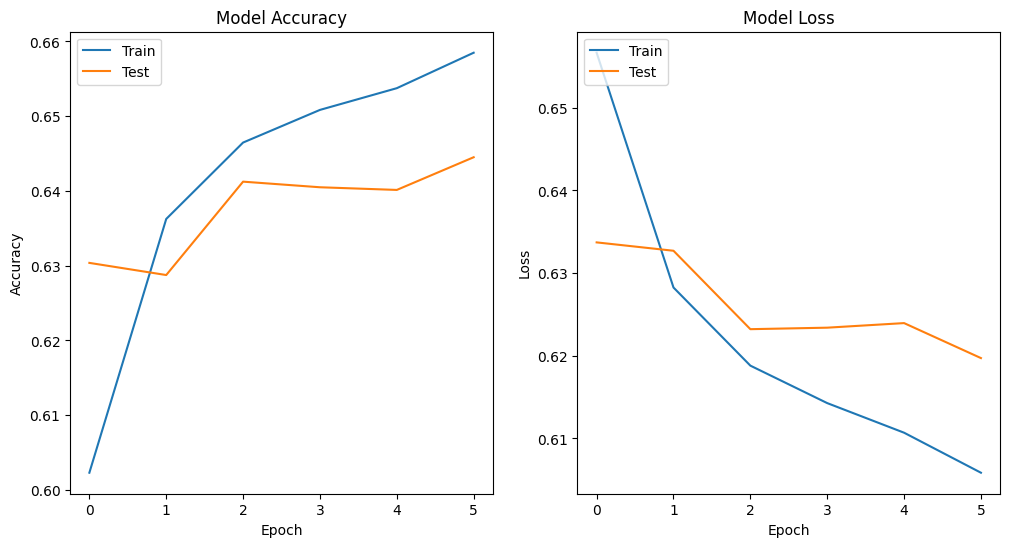

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()

# C. Classification avec un réseau de neurones récurrent (LSTM)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Création du modèle séquentiel
model = Sequential()

# Ajout de la couche d'embedding
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen))

# Ajout de la couche LSTM
model.add(LSTM(units=128))

# Ajout de la couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 348s 1s/step - loss: 0.4176 - acc: 0.8027 - val_loss: 0.3555 - val_acc: 0.8535
Epoch 2/6
250/250 [==============================] - 336s 1s/step - loss: 0.2917 - acc: 0.8790 - val_loss: 0.3547 - val_acc: 0.8460
Epoch 3/6
250/250 [==============================] - 313s 1s/step - loss: 0.2510 - acc: 0.8996 - val_loss: 0.3777 - val_acc: 0.8474
Epoch 4/6
250/250 [==============================] - 332s 1s/step - loss: 0.2165 - acc: 0.9137 - val_loss: 0.3813 - val_acc: 0.8481
Epoch 5/6
250/250 [==============================] - 350s 1s/step - loss: 0.1796 - acc: 0.9315 - val_loss: 0.4034 - val_acc: 0.8472
Epoch 6/6
250/250 [==============================] - 328s 1s/step - loss: 0.1477 - acc: 0.9453 - val_loss: 0.4908 - val_acc: 0.8405


In [ ]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

print("Shape of X_train:", X_train .shape)
print("Shape of y_train:", y_train.shape)


Shape of X_test: (10000, 100)
Shape of y_test: (10000,)
Shape of X_train: (40000, 100)
Shape of y_train: (40000,)


In [ ]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 9372077 (35.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluation du modele

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


313/313 [==============================] - 22s 69ms/step - loss: 0.4659 - acc: 0.8454
Test Loss: 0.46591323614120483
Test Accuracy: 0.8453999757766724


### Traçage des fonctions de loss et de accuracy pour les training et test sets


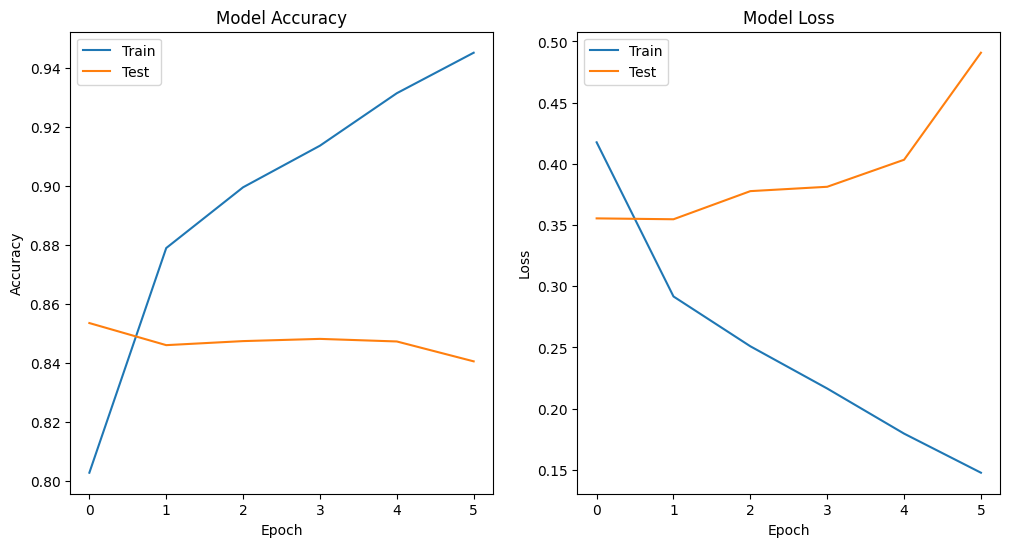

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()

# Compte Rendu

## Modèle GRU (Gated Recurrent Unit):

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

# Création du modèle séquentiel
model_gru = Sequential()

# Ajout de la couche d'embedding
model_gru.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen))

# Ajout de la couche GRU
model_gru.add(GRU(units=128))

# Ajout de la couche Dense
model_gru.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history_gru = model_gru.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 299s 1s/step - loss: 0.4304 - acc: 0.7945 - val_loss: 0.3431 - val_acc: 0.8550
Epoch 2/6
250/250 [==============================] - 314s 1s/step - loss: 0.2846 - acc: 0.8833 - val_loss: 0.3185 - val_acc: 0.8656
Epoch 3/6
250/250 [==============================] - 295s 1s/step - loss: 0.2324 - acc: 0.9095 - val_loss: 0.3591 - val_acc: 0.8616
Epoch 4/6
250/250 [==============================] - 349s 1s/step - loss: 0.1862 - acc: 0.9298 - val_loss: 0.3797 - val_acc: 0.8536
Epoch 5/6
250/250 [==============================] - 309s 1s/step - loss: 0.1445 - acc: 0.9469 - val_loss: 0.4344 - val_acc: 0.8541
Epoch 6/6
250/250 [==============================] - 336s 1s/step - loss: 0.1157 - acc: 0.9601 - val_loss: 0.4753 - val_acc: 0.8426


In [ ]:
score_gru = model_gru.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 17s 54ms/step - loss: 0.4448 - acc: 0.8522
Test Loss: 0.46591323614120483
Test Accuracy: 0.8453999757766724


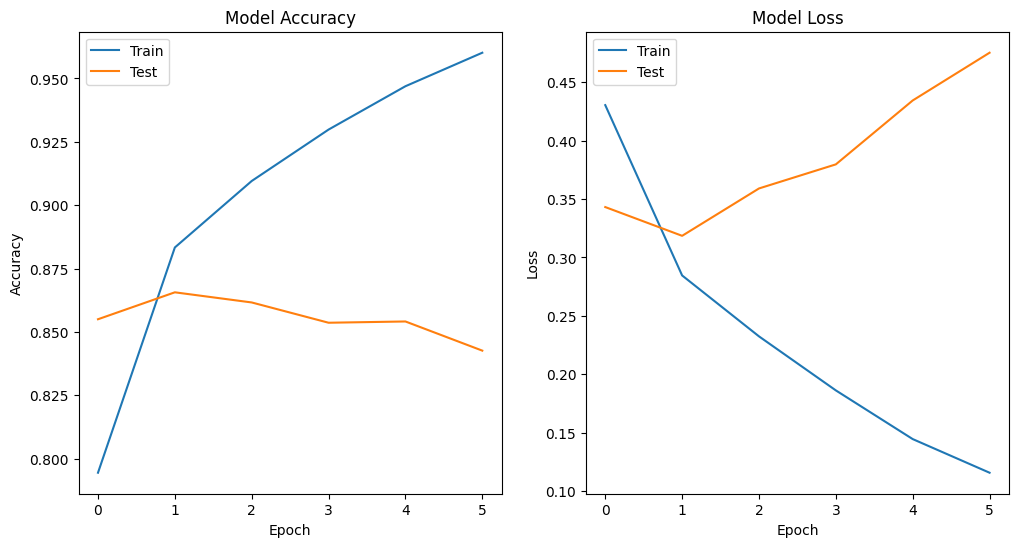

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['acc'])
plt.plot(history_gru.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()

## Modèle RNN + CNN :

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten

# Création du modèle séquentiel
model_rnn_cnn = Sequential()

# Ajout de la couche d'embedding
model_rnn_cnn.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen))

# Ajout de la couche Conv1D
model_rnn_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Ajout de la couche de pooling MaxPooling1D
model_rnn_cnn.add(MaxPooling1D())

# Ajout de la couche LSTM
model_rnn_cnn.add(LSTM(units=128))

# Ajout de la couche Dense
model_rnn_cnn.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model_rnn_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history_rnn_cnn = model_rnn_cnn.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 38s 126ms/step - loss: 0.4079 - acc: 0.8068 - val_loss: 0.3171 - val_acc: 0.8645
Epoch 2/6
250/250 [==============================] - 12s 50ms/step - loss: 0.2671 - acc: 0.8911 - val_loss: 0.3209 - val_acc: 0.8635
Epoch 3/6
250/250 [==============================] - 7s 27ms/step - loss: 0.2186 - acc: 0.9147 - val_loss: 0.3277 - val_acc: 0.8586
Epoch 4/6
250/250 [==============================] - 7s 27ms/step - loss: 0.1501 - acc: 0.9455 - val_loss: 0.3952 - val_acc: 0.8511
Epoch 5/6
250/250 [==============================] - 6s 22ms/step - loss: 0.0873 - acc: 0.9718 - val_loss: 0.4408 - val_acc: 0.8511
Epoch 6/6
250/250 [==============================] - 5s 22ms/step - loss: 0.0604 - acc: 0.9803 - val_loss: 0.5231 - val_acc: 0.8426


In [ ]:
score_rnn_cnn = model_rnn_cnn.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score_rnn_cnn[0])
print("Test Accuracy:", score_rnn_cnn[1])

313/313 [==============================] - 3s 9ms/step - loss: 0.4888 - acc: 0.8509
Test Loss: 0.48876067996025085
Test Accuracy: 0.8508999943733215


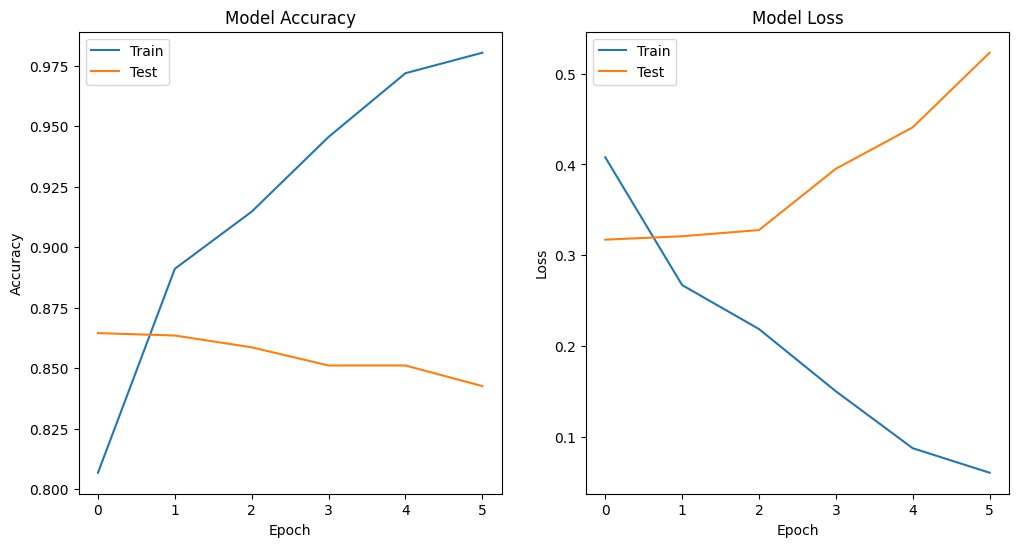

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_rnn_cnn.history['acc'])
plt.plot(history_rnn_cnn.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn_cnn.history['loss'])
plt.plot(history_rnn_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()

## Using Word2Vec:

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

word2vec_path = '/content/drive/MyDrive/Tp4Dataset/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [ ]:
embedding_size = word2vec_model.vector_size
print("Taille des embeddings :", embedding_size)


Taille des embeddings : 300


In [ ]:
# Créer une matrice d'embeddings
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = word2vec_model[word]

## Using FastText:

In [ ]:
from gensim.models import KeyedVectors
import numpy as np

# Path to the pre-trained FastText model embeddings
fastText_path = "/content/drive/MyDrive/Tp4Dataset/cc.en.300.vec"

# Load the FastText model from the path
fastText_model = KeyedVectors.load_word2vec_format(fastText_path, binary=False)



In [ ]:
embedding_size = fastText_model.vector_size
print(embedding_size)

300


In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    if word in fastText_model:
        embedding_matrix[index] = fastText_model[word]


## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_0)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_0)

# Normalize TF-IDF vectors
X_train_tfidf_normalized = normalize(X_train_tfidf, norm='l2')
X_test_tfidf_normalized = normalize(X_test_tfidf, norm='l2')

# Convert TF-IDF vectors into sequences
X_train_seq = []
X_test_seq = []
maxlen = 100  # Max sequence length

# Convert training data
for tfidf_vector in X_train_tfidf_normalized:
    sequence = tfidf_vector.indices.tolist()[:maxlen]  # Consider only the indices with highest TF-IDF values
    X_train_seq.append(sequence)

# Convert test data
for tfidf_vector in X_test_tfidf_normalized:
    sequence = tfidf_vector.indices.tolist()[:maxlen]  # Consider only the indices with highest TF-IDF values
    X_test_seq.append(sequence)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)


# Get the embedding matrix
embedding_matrix = np.zeros((len(tfidf_vectorizer.vocabulary_) + 1, X_train_tfidf_normalized.shape[1]))  # +1 for unknown words
for word, i in tfidf_vectorizer.vocabulary_.items():
    embedding_matrix[i] = X_train_tfidf_normalized[i].toarray().flatten()



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Get the embedding dimension
embedding_dim = X_train_tfidf_normalized.shape[1]

# Create the LSTM model
vocab_size = len(tfidf_vectorizer.vocabulary_) + 1  # Vocabulary size
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 90s 333ms/step - loss: 0.6934 - acc: 0.5029 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/6
250/250 [==============================] - 82s 327ms/step - loss: 0.6934 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/6
250/250 [==============================] - 77s 308ms/step - loss: 0.6933 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/6
250/250 [==============================] - 77s 307ms/step - loss: 0.6931 - acc: 0.5045 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 5/6
250/250 [==============================] - 75s 298ms/step - loss: 0.6922 - acc: 0.5183 - val_loss: 0.6923 - val_acc: 0.5155
Epoch 6/6
250/250 [==============================] - 78s 314ms/step - loss: 0.6909 - acc: 0.5318 - val_loss: 0.6924 - val_acc: 0.5282


In [ ]:
print(embedding_dim)
print(vocab_size)

100
101


In [ ]:
score = model.evaluate(X_test_pad, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 29s 93ms/step - loss: 0.6928 - acc: 0.5238
Test Score: 0.6927593350410461
Test Accuracy: 0.5238000154495239


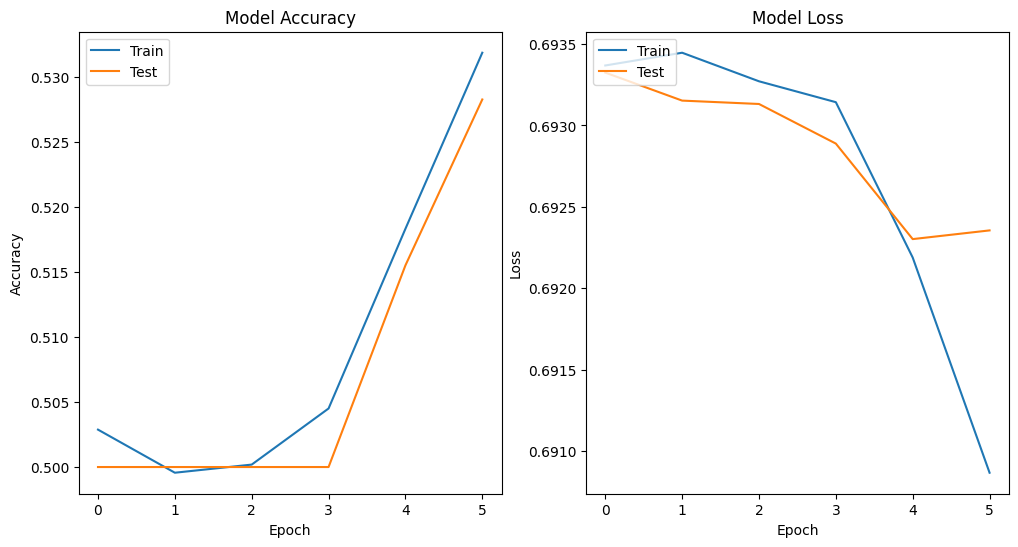

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()